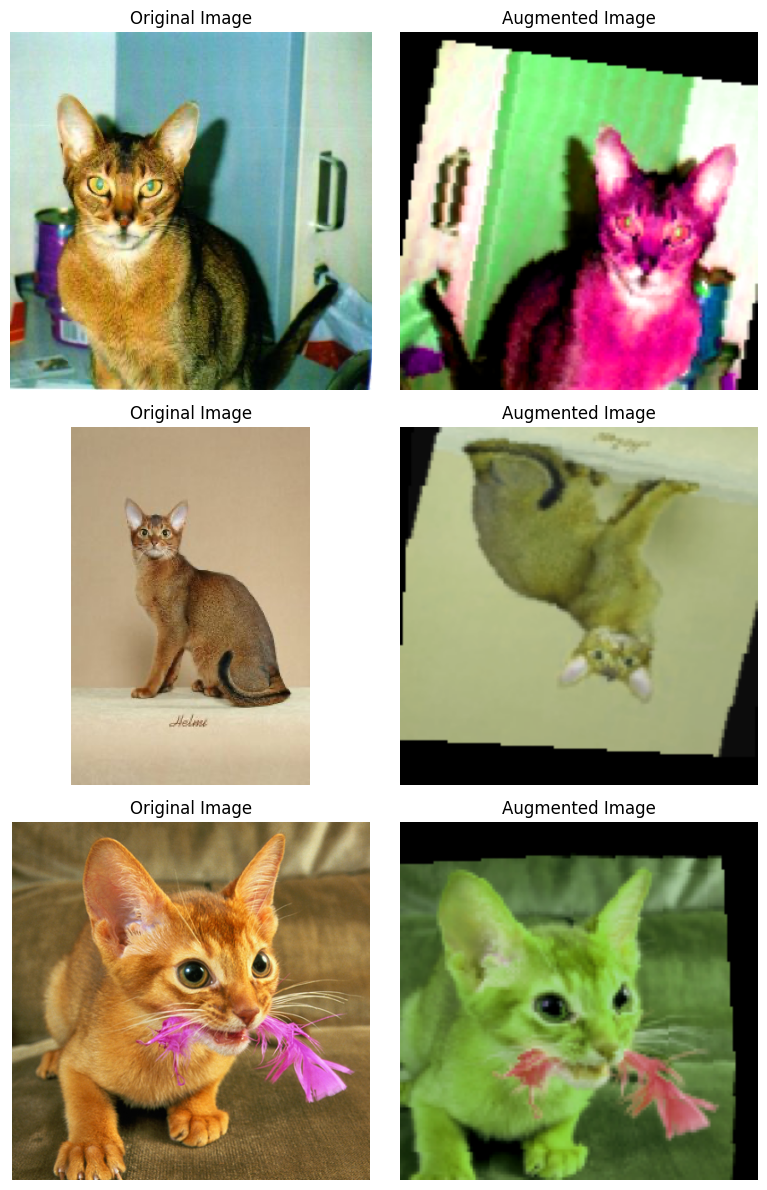

Original training set size: 2567 images
Augmented training set size: 2567 images
Combined training set size: 5134 images (Original + Augmented)
Combined dataset saved as 'combined_train_set.pth'.


In [1]:
import torch
from torchvision import transforms
from datasets import load_dataset
from torch.utils.data import Dataset, ConcatDataset, DataLoader
import matplotlib.pyplot as plt

augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

# Define a custom Dataset class that applies augmentations
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, transform=None):
        self.original_dataset = original_dataset
        self.transform = transform
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, index):
        sample = self.original_dataset[index]
        img, label = sample['img'], sample['class']

        original_img = img
        if self.transform:
            img = self.transform(img)

        return {'original_img': original_img, 'augmented_img': img, 'class': torch.tensor(label, dtype=torch.long)}


def load_data(data_augmentation=False):
    """
    Loads the original dataset and applies transformations, optionally combining with augmented data.
    """
    dataset = load_dataset("cvdl/oxford-pets")
    original_train_set = dataset['train']
    original_valid_set = dataset['test'] 

    if data_augmentation:
        augmented_train_set = AugmentedDataset(original_train_set, transform=augmentation_transforms)
        combined_train_set = ConcatDataset([original_train_set, augmented_train_set])
    else:
        combined_train_set = original_train_set

    # Create data loaders for both training and validation sets
    data_loader_train = DataLoader(combined_train_set, batch_size=32, shuffle=True)
    data_loader_valid = DataLoader(original_valid_set, batch_size=32)

    return data_loader_train, data_loader_valid

def load_and_combine_data():
    """
    Loads the dataset, applies augmentations, and combines the original dataset with augmented data.
    """
    # Load the original training dataset
    dataset = load_dataset("cvdl/oxford-pets")
    dataset = dataset.select_columns(["img", "class"])
    original_train_set = dataset["train"] 
    
    print(f"Original training set size: {len(original_train_set)} images")

    # Create augmented dataset
    augmented_train_set = AugmentedDataset(original_train_set, transform=augmentation_transforms)
    print(f"Augmented training set size: {len(augmented_train_set)} images")
    # Combine the original dataset with the augmented dataset
    combined_train_set = ConcatDataset([original_train_set, augmented_train_set])
    print(f"Combined training set size: {len(combined_train_set)} images (Original + Augmented)")

    return combined_train_set

def visualize_augmentations():
    dataset = load_dataset("cvdl/oxford-pets")
    original_train_set = dataset["train"]

    augmented_dataset = AugmentedDataset(original_train_set, transform=augmentation_transforms)

    fig, axes = plt.subplots(3, 2, figsize=(8, 12))  # 3 pairs of images
    for i in range(3):
        sample = augmented_dataset[i]
        original_img = sample['original_img']
        augmented_img = sample['augmented_img']

        # Convert tensors back to PIL images
        augmented_img = transforms.ToPILImage()(augmented_img)

        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(augmented_img)
        axes[i, 1].set_title("Augmented Image")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

visualize_augmentations()

def visualize_combined_dataset():
    combined_dataset = load_and_combine_data()  # Load dataset with original + augmented images

    fig, axes = plt.subplots(3, 2, figsize=(8, 12))

    for i in range(3):
        sample_original = combined_dataset[i]  # Original dataset
        sample_augmented = combined_dataset[len(combined_dataset)//2 + i]  # Augmented dataset (starts after original dataset)

        # Original dataset may store images under 'img', but augmented dataset stores them under 'augmented_img'
        original_img = sample_original.get('img') or sample_original.get('original_img')
        augmented_img = sample_augmented.get('augmented_img')  # Fix the key

        # Convert tensors back to PIL images
        if isinstance(original_img, torch.Tensor):
            original_img = transforms.ToPILImage()(original_img)
        if isinstance(augmented_img, torch.Tensor):
            augmented_img = transforms.ToPILImage()(augmented_img)

        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(augmented_img)
        axes[i, 1].set_title("Augmented Image")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()



def save_combined_dataset():
    """
    Combines the dataset and saves it as a .pth file.
    """
    combined_train_set = load_and_combine_data()
    torch.save(combined_train_set, "combined_train_set.pth")
    print("Combined dataset saved as 'combined_train_set.pth'.")

if __name__ == "__main__":
    save_combined_dataset()
